## Facial Emotion Recognition using Neural Network
### Functions that read data from CSV file into arrays

In [1]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import brewer2mpl


def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(usage='Training',classes=['Angry','Happy'], filepath='fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

Using TensorFlow backend.


In [3]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

file_path = 'fer2013.csv'

X_test, y_test = load_data(classes=emo, usage='PrivateTest', filepath=file_path)
X_train, y_train = load_data(classes=emo, usage='Training', filepath=file_path)
X_val,y_val = load_data(classes=emo, usage='PublicTest', filepath=file_path)

Disgust classified as Angry
Disgust classified as Angry
Disgust classified as Angry


## Model Architecture and Training

In [4]:
# Final Model Architecture:

##### TODO: change the parameter to improve the accuracy 
##### (Batch_size, nb_epoch, activation= relu, sigmoid, tanh, layers)
from keras import layers
from keras import models
from keras import optimizers

modelN = models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(6, activation='softmax'))

# optimizer:
modelN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print ('Training....')


# fit
nb_epoch = 3
batch_size = 256

modelF = modelN.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=batch_size,
          validation_data=(X_val, y_val), shuffle=True, verbose=1)

Training....
Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 336s 12ms/step - loss: 1.7626 - acc: 0.2497 - val_loss: 1.7442 - val_acc: 0.2494
Epoch 2/3
28709/28709 [==============================] - 365s 13ms/step - loss: 1.7190 - acc: 0.2666 - val_loss: 1.6683 - val_acc: 0.3266
Epoch 3/3
28709/28709 [==============================] - 326s 11ms/step - loss: 1.5263 - acc: 0.3855 - val_loss: 1.4461 - val_acc: 0.4299


## Save model and plot accuracy

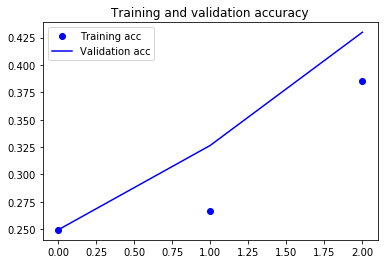

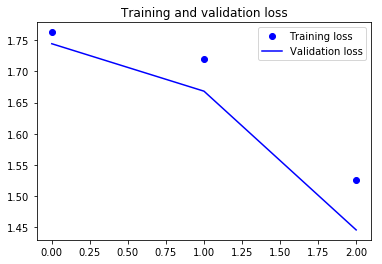

In [5]:
modelN.save('facial_expression_model')
modelN.save_weights('facial_expression_weights.h5')

acc = modelF.history['acc']
val_acc = modelF.history['val_acc']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Load private test set

In [6]:
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (labels)
print (counts)

Private test set
['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
[546 528 879 594 416 626]


### Evaluate private test set

In [7]:
# evaluate model on private test set
score = modelN.evaluate(X, y, verbose=0)
print ("model %s: %.2f%%" % (modelN.metrics_names[1], score[1]*100))

model acc: 42.38%


### Prediction on private test set

In [8]:
# prediction and true labels
y_prob = modelN.predict(X, batch_size=32, verbose=0)
##### TODO: Change the y_prob and y from binary arrays to integer 
##### and call them y_pred and y_true ###########################
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]
#################################################################

In [9]:
import matplotlib
def plot_subjects(start, end, y_pred, y_true, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [10]:
import brewer2mpl
def plot_probs(start,end, y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [11]:
def plot_subjects_with_probs(start, end, y_prob):
    """
    This plotting function is used to plot the probability together with its picture
    """
    iter = int((end - start)/6)
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

### Plot subjects and probability for n images usin functions above

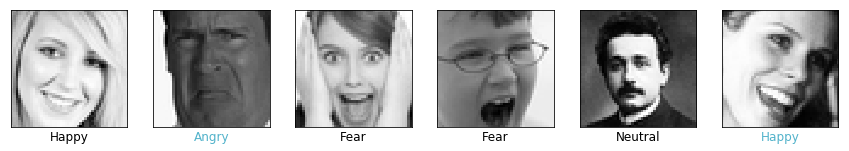

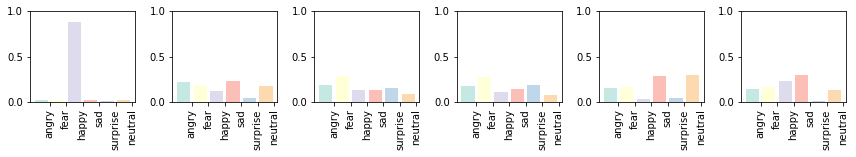

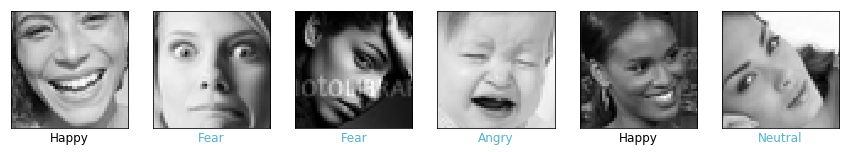

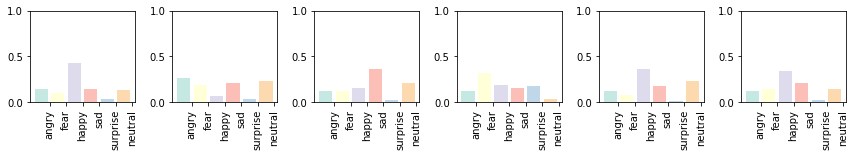

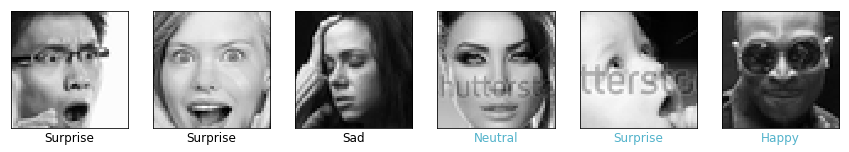

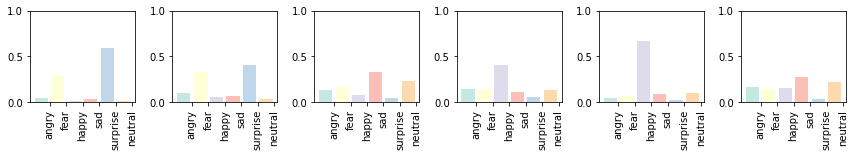

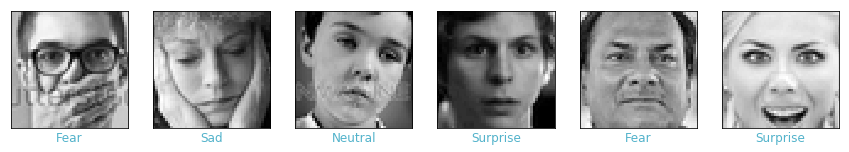

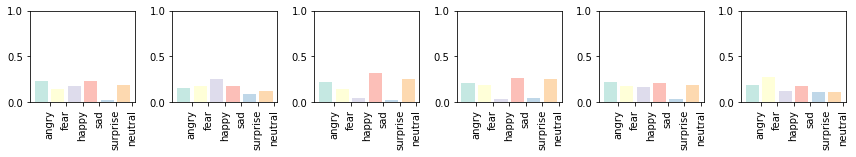

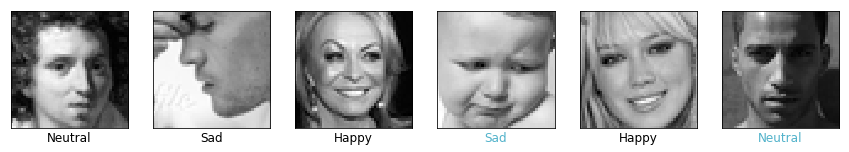

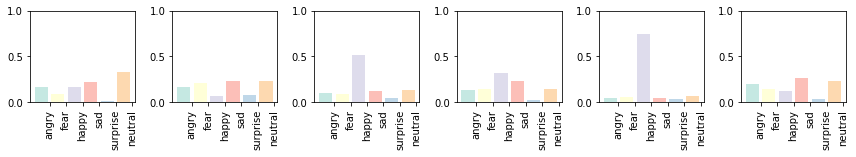

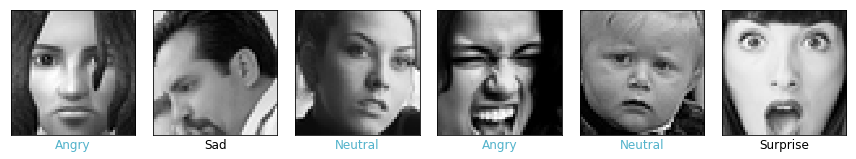

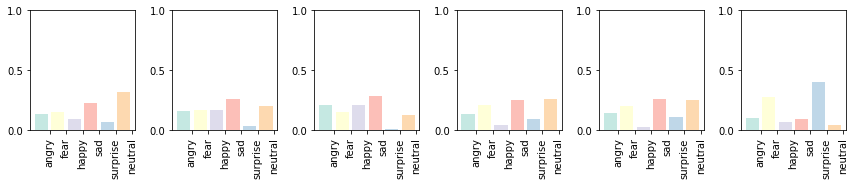

In [12]:
##### TODO: plot subjects and probs for n images
n = 36
plot_subjects_with_probs(0, n, y_prob)
################################################

## Compare true and prediction results

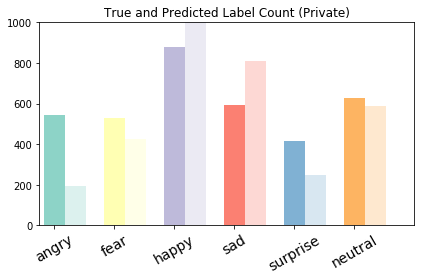

In [13]:
### TODO: Create a function to compare the number of true labels and prediction results

def plot_distribution2(y_true, y_pred):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
######################################################################################
plot_distribution2(y_true, y_pred)

### Plot confusion matrix

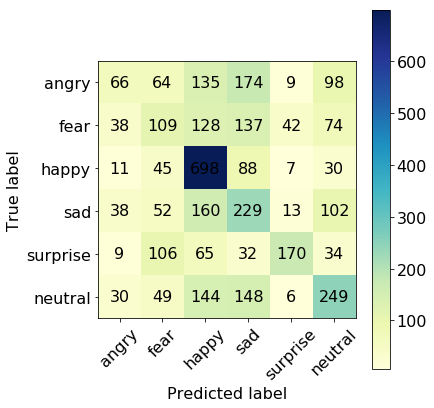

In [14]:
import matplotlib
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

## Prediction on own data

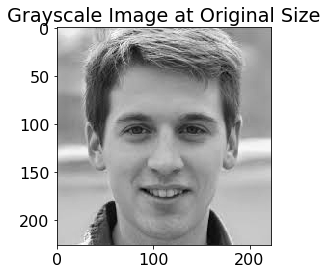

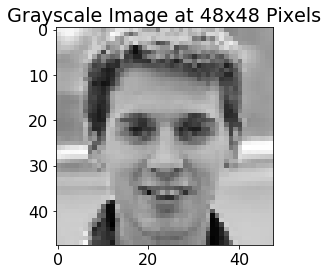

In [15]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##### TODO: read in your image
input_img = imread('sample.jpg', as_gray=True)

##############################

plt.imshow(input_img, cmap='gray')
plt.title('Grayscale Image at Original Size')
plt.show()

resized_img = resize(input_img, output_shape=(48, 48))

plt.imshow(resized_img, cmap='gray')
plt.title("Grayscale Image at 48x48 Pixels")
plt.show()

### Assign emotion label your image

In [38]:
##### TODO: give your image a label, set y_true
y_true = 2
###############################################

### Process image for input to network¶

In [30]:
import numpy as np
img_array = np.array(resized_img)
img_array = img_array.reshape(1, 48, 48,1)
img_array = img_array.astype("float32")
img_array /= 255
print(img_array)

[[[[0.00357025]
   [0.0036011 ]
   [0.00364499]
   ...
   [0.00241427]
   [0.00246608]
   [0.00251029]]

  [[0.00335408]
   [0.00355533]
   [0.00364499]
   ...
   [0.00244557]
   [0.00247065]
   [0.00249578]]

  [[0.00313765]
   [0.00325745]
   [0.00338227]
   ...
   [0.00241947]
   [0.00245795]
   [0.00247932]]

  ...

  [[0.00308114]
   [0.0031119 ]
   [0.00309652]
   ...
   [0.00309874]
   [0.00309874]
   [0.00308064]]

  [[0.00306576]
   [0.00306576]
   [0.00309652]
   ...
   [0.0031005 ]
   [0.00308336]
   [0.00306526]]

  [[0.00305223]
   [0.00305936]
   [0.00309876]
   ...
   [0.00309999]
   [0.00308546]
   [0.0030679 ]]]]


### Predict emotion of our image

In [31]:
y_prob = modelN.predict(img_array, batch_size=1, verbose=0)
y_pred = [np.argmax(y_prob)]

In [41]:
import matplotlib
def plot_subject(y_pred, y_true, img, title=False):
    """
    The function is used to plot the picture subjects
    """
    fig = plt.figure(figsize=(4,4))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    plt.imshow(img, cmap=matplotlib.cm.gray)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    if y_pred != y_true:
        plt.xlabel(emotion[y_true], color='#53b3cb',fontsize=12)
    else:
        plt.xlabel(emotion[y_true], fontsize=12)
    if title:
        plt.title(emotion[y_pred], color='blue')
    plt.tight_layout()
    plt.show()
import brewer2mpl
def plot_prob(y_prob):
    """
    The function is used to plot the probability in histogram for six labels 
    """
    fig = plt.figure(figsize=(4,4))
    set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    ax = plt.gca()
    ax.bar(np.arange(0,6), y_prob[0], color=set3,alpha=0.5)
    ax.set_xticks(np.arange(0.5,6.5,1))
    labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_yticks(np.arange(0.0,1.1,0.5))
    plt.tight_layout()
    plt.show()

def plot_subject_with_prob(img, y_prob, y_pred, y_true):
    """
    This plotting function is used to plot the probability together with its picture
    """
    plot_subject(y_pred, y_true, img, title=False)
    plot_prob(y_prob)

## Plot image and probabilities using above function

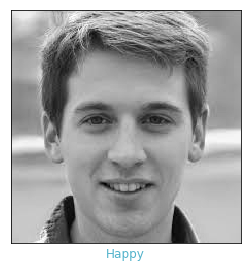

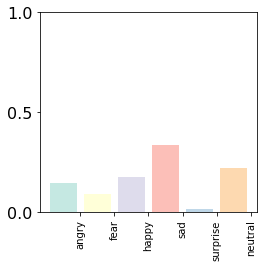

In [43]:
##### TODO: Plot image and probabilities
plot_subject_with_prob(input_img, y_prob, y_pred, y_true)
########################################